# Template for reinforcement learning applied to the CartPole benchmark

A lot of (better) code taken from https://github.com/ageron/handson-ml

# Settings

In [12]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import gym
import numpy as np
import bisect
import math
import os
import random
import tensorflow as tf

from agents.random_agent import run_episode_random_agent
from agents.human_crafted_agent import human_decision, run_episode_human_crafted_agent

tf.logging.set_verbosity(tf.logging.WARN)  # Remove Info logs

In [13]:
env = gym.make("CartPole-v1")

In [17]:
print(env.action_space)  # 0 or 1

obs = env.reset()
print(obs)  # position, velocity, angle, angular_velocity
print(env._max_episode_steps)

observation_space_dimension = env.observation_space.shape[0]
print(observation_space_dimension)

Discrete(2)
[-0.03492443 -0.01343875 -0.00758664 -0.00111444]
500
4


# Q-learning

## Observing the values

In [18]:
nb_episodes = 1000
positions = []
velocities = []
angles = []
angular_velocities = []

for episode in range(0, nb_episodes):
    obs = env.reset()
    done = False
    final_score = 0

    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        position, velocity, angle, angular_velocity = obs
        positions.append(position)
        velocities.append(velocity)
        angles.append(angle)
        angular_velocities.append(angular_velocity)        

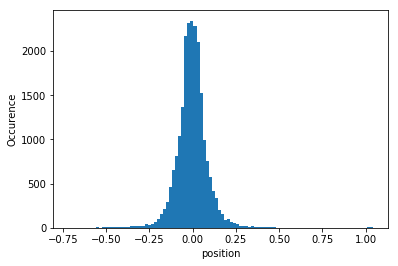

In [19]:
plt.hist(positions, bins=100)
plt.xlabel('position');
plt.ylabel('Occurence');

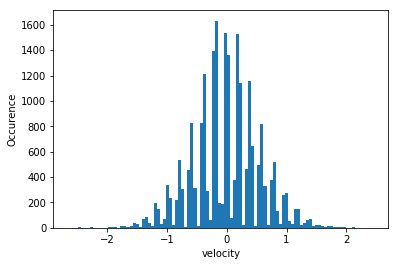

In [20]:
plt.hist(velocities, bins=100)
plt.xlabel('velocity');
plt.ylabel('Occurence');

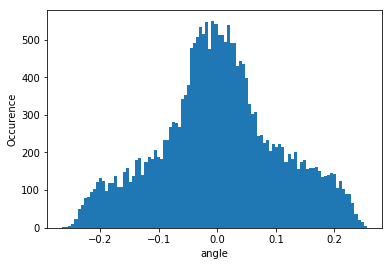

In [21]:
plt.hist(angles, bins=100)
plt.xlabel('angle');
plt.ylabel('Occurence');

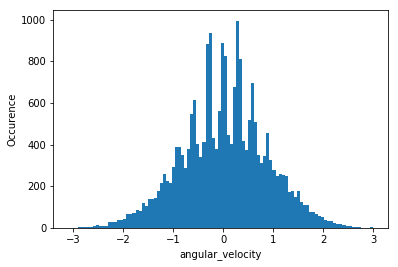

In [22]:
plt.hist(angular_velocities, bins=100)
plt.xlabel('angular_velocity');
plt.ylabel('Occurence');

# Policy gradient

## Computational graph

In [ ]:
tf.reset_default_graph()

nb_neurons_input = 4  # len(obs)
nb_neurons_hidden_layer = 4
nb_neurons_output = 1

X = tf.placeholder(shape=[None, nb_neurons_input], dtype=tf.float32, name="X")

with tf.name_scope("dnn"): 
    initializer_w = tf.contrib.layers.xavier_initializer()
    initializer_b = tf.zeros_initializer() 
    hidden = tf.layers.dense(X, nb_neurons_hidden_layer, \
                             activation=tf.nn.elu, \
                             kernel_initializer=tf.contrib.layers.xavier_initializer(), \
                             name="hidden")
    output = tf.layers.dense(hidden, nb_neurons_output, 
                             activation=tf.nn.sigmoid,
                             name="output")  # proba of moving kart to left

init = tf.global_variables_initializer()

## Playing an episode - before training

In [ ]:
def run_episode_neural_network(show_renderer=False):    
    with tf.Session() as sess:
        init.run()
        obs = env.reset()
        obs_pretty = obs.reshape(1, nb_neurons_input)
        done = False
        final_score = 0
        while not done:
            if show_renderer:
                env.render()
            proba_move_to_left = output.eval(feed_dict={X: obs_pretty})        
            if random.uniform(0, 1) < proba_move_to_left:
                action = 0  # move to left
            else:
                action = 1       
            obs, reward, done, info = env.step(action) 
            if done:
                break
            final_score += reward
    env.reset()
    env.close()
    return final_score

In [ ]:
scores = []
nb_episodes = 100

for i in range(0, nb_episodes):
    episode_score = run_episode_neural_network()
    scores.append(episode_score)

In [ ]:
print(np.mean(scores))
plt.plot(scores)
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()

## Training the neural net to imitate the human crafted policy

In [ ]:
tf.reset_default_graph()

nb_neurons_input = 4  # len(obs)
nb_neurons_hidden_layer = 4
nb_neurons_output = 1
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, nb_neurons_input], name="X")
y = tf.placeholder(tf.float32, shape=[None, nb_neurons_output], name="y")

with tf.name_scope("dnn"): 
    initializer_w = tf.contrib.layers.xavier_initializer()
    initializer_b = tf.zeros_initializer() 
    
    hidden = tf.layers.dense(X, nb_neurons_hidden_layer, \
                             activation=tf.nn.elu, \
                             kernel_initializer=tf.contrib.layers.xavier_initializer(), \
                             name="hidden")
    logits = tf.layers.dense(hidden, nb_neurons_output, 
                             name="logits")  
    estimated_action_value = tf.nn.sigmoid(logits, name="estimated_action_value")  # 0 => left, 1 => right
    p_left_and_right = tf.concat(axis=1, values=[1 - estimated_action_value, estimated_action_value])
    estimated_action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
nb_training_episode = 2000
tf_logs_dir = os.path.join(".", "save", "tf_logs", "imitation_neural_net")
if not os.path.isdir(tf_logs_dir):
    os.makedirs(tf_logs_dir)
tf_log_file = os.path.join(tf_logs_dir, "imitation_neural_net.ckpt")

with tf.Session() as sess:
    init.run()
    for episode in range(nb_training_episode):
        step = 0
        done = False
        episode_score, reward = 0, 0    
        obs = env.reset()
        while not done:         
            position, velocity, angle, angular_velocity = obs
            obs_pretty = obs.reshape(1, nb_neurons_input)
            target_action = human_decision(angle)
            target_action = np.array([target_action]).reshape(1, 1)     
            action_val, _ = sess.run([estimated_action, training_op], feed_dict={X: obs_pretty, y: target_action})  
            selected_action = action_val[0][0]            
            obs, reward, done, info = env.step(selected_action)                
    saver.save(sess, tf_log_file)

In [ ]:
def run_episode_neural_network(tf_log_file, show_renderer=False): 
    with tf.Session() as sess:
        saver.restore(sess, tf_log_file)
        obs = env.reset()
        done = False
        final_score = 0
        while not done:
            if show_renderer:
                env.render()
            obs_pretty = obs.reshape(1, nb_neurons_input)
            estimated_action = estimated_action_value.eval(feed_dict={X: obs_pretty}) 
            estimated_action = estimated_action[0][0]    
            if estimated_action > 0.5:
                action = 1
            else:
                action = 0  
            obs, reward, done, info = env.step(action)
            final_score += reward
    env.reset()
    env.close()
    return final_score

In [ ]:
tf_logs_dir = os.path.join(".", "save", "tf_logs", "imitation_neural_net")
if not os.path.isdir(tf_logs_dir):
    os.makedirs(tf_logs_dir)
tf_log_file = os.path.join(tf_logs_dir, "imitation_neural_net.ckpt")

In [ ]:
scores = []
nb_episodes = 100

for i in range(0, nb_episodes):
    episode_score = run_episode_neural_network(tf_log_file)
    scores.append(episode_score)

In [ ]:
print(np.mean(scores))
plt.plot(scores)
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()

## Actual policy gradient

In [ ]:
tf.reset_default_graph()

nb_neurons_input = 4  # len(obs)
nb_neurons_hidden_layer = 4
nb_neurons_output = 1
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, nb_neurons_input], name="X")
y = tf.placeholder(tf.float32, shape=[None, nb_neurons_output], name="y")

with tf.name_scope("dnn"): 
    initializer_w = tf.contrib.layers.xavier_initializer()
    initializer_b = tf.zeros_initializer() 
    
    hidden = tf.layers.dense(X, nb_neurons_hidden_layer, \
                             activation=tf.nn.elu, \
                             kernel_initializer=tf.contrib.layers.xavier_initializer(), \
                             name="hidden")
    logits = tf.layers.dense(hidden, nb_neurons_output, 
                             name="logits")  
    estimated_action_value = tf.nn.sigmoid(logits, name="estimated_action_value")  # 0 => left, 1 => right
    p_left_and_right = tf.concat(axis=1, values=[1 - estimated_action_value, estimated_action_value])
    tentative_action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

    
    
y = tf.to_float(tentative_action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [ ]:
tf.reset_default_graph()

nb_neurons_input = 4  # len(obs)
nb_neurons_hidden_layer = 4
nb_neurons_output = 1

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, nb_neurons_input])

with tf.name_scope("dnn"): 
    initializer_w = tf.contrib.layers.xavier_initializer()
    initializer_b = tf.zeros_initializer() 
    
    hidden = tf.layers.dense(X, nb_neurons_hidden_layer, \
                             activation=tf.nn.elu, \
                             kernel_initializer=tf.contrib.layers.xavier_initializer(), \
                             name="hidden")
    logits = tf.layers.dense(hidden, nb_neurons_output, 
                             name="logits")  
    estimated_action_value = tf.nn.sigmoid(logits, name="estimated_action_value")  # 0 => left, 1 => right
    p_left_and_right = tf.concat(axis=1, values=[1 - estimated_action_value, estimated_action_value])
    tentative_action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = tf.to_float(tentative_action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
nb_training_sessions = 250
nb_episodes_per_training_session = 10
save_iterations = 10
discount_rate = 0.95
tf_logs_dir = os.path.join(".", "save", "tf_logs", "policy_gradient_neural_net")
if not os.path.isdir(tf_logs_dir):
    os.makedirs(tf_logs_dir)
tf_log_file = os.path.join(tf_logs_dir, "policy_gradient_neural_net.ckpt")

with tf.Session() as sess:
    init.run()  # TODO: restore the previous network which imitates the human behaviour
    for training_session in range(nb_training_sessions):
        print("Training session: {}".format(training_session))        
        all_rewards = []
        all_gradients = []
        for episode in range(nb_episodes_per_training_session):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            done = False
            while not done: 
                action_val, gradients_val = sess.run([tentative_action, gradients], feed_dict={X: obs.reshape(1, nb_neurons_input)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if training_session % save_iterations == 0:
            saver.save(sess, tf_log_file)

In [ ]:
def run_episode_neural_network(tf_log_file, show_renderer=False): 
    with tf.Session() as sess:
        saver.restore(sess, tf_log_file)
        obs = env.reset()
        done = False
        final_score = 0
        while not done:
            if show_renderer:
                env.render()
            obs_pretty = obs.reshape(1, nb_neurons_input)
            estimated_action = estimated_action_value.eval(feed_dict={X: obs_pretty}) 
            estimatedestimated_action_action = estimated_action[0][0]    
            if estimated_action > 0.5:
                action = 1
            else:
                action = 0  
            obs, reward, done, info = env.step(action)
            final_score += reward
    env.reset()
    env.close()
    return final_score

In [ ]:
tf_logs_dir = os.path.join(".", "save", "tf_logs", "policy_gradient_neural_net")
if not os.path.isdir(tf_logs_dir):
    os.makedirs(tf_logs_dir)
tf_log_file = os.path.join(tf_logs_dir, "policy_gradient_neural_net.ckpt")

In [ ]:
scores = []
nb_episodes = 100

for i in range(0, nb_episodes):
    episode_score = run_episode_neural_network(tf_log_file, False)
    scores.append(episode_score)

In [ ]:
print(np.mean(scores))
plt.plot(scores)